In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from scipy.stats import linregress
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
!ls

IR-data.xlsx        README.md           Vasicek-model.ipynb


In [111]:
ir = pd.read_excel('IR-data.xlsx')
ir['delta'] = ir['Interest rate'].diff()
# ir.loc[:, ['Interest rate', 'delta']] = ir.loc[:, ['Interest rate', 'delta']].multiply(0.01)
ir = ir.rename(columns={'Interest rate': 'interest_rate'})
# ir = ir.bfill()
ir = ir.dropna()
ir

,Date,interest_rate,delta
1,2011-01-06,4.13,-0.07
2,2011-01-13,4.08,-0.05
3,2011-01-20,4.05,-0.03
4,2011-01-27,4.09,0.04
5,2011-02-03,4.08,-0.01
...,...,...,...
582,2022-02-24,3.14,-0.01
583,2022-03-03,3.01,-0.13
584,2022-03-10,3.09,0.08
585,2022-03-17,3.39,0.30


In [24]:
ir = pd.read_csv('DGS10.csv', parse_dates=['DATE'])
ir = ir.rename(columns={'DATE': 'Date', 'IR': 'interest_rate'})

# replace '.' with NaN
ir = ir.replace('.', np.nan)
ir = ir.dropna()
ir['interest_rate'] = ir['interest_rate'].astype(float)
ir.to_csv('DGS10_cleaned.csv', index=False)
ir['delta'] = ir['interest_rate'].diff()
ir = ir.dropna()

ir

,Date,interest_rate,delta
1,2007-03-07,4.50,-0.03
2,2007-03-08,4.51,0.01
3,2007-03-09,4.59,0.08
4,2007-03-12,4.56,-0.03
5,2007-03-13,4.50,-0.06
...,...,...,...
4562,2024-08-29,3.87,0.03
4563,2024-08-30,3.91,0.04
4565,2024-09-03,3.84,-0.07
4566,2024-09-04,3.77,-0.07


In [8]:
train = ir.loc[ir['Date'] < '2021-01-01', :]
test = ir.loc[ir['Date'] >= '2021-01-01', :]

# x_train = sm.add_constant(train['interest_rate'])
x_train = train.loc[:, 'interest_rate']
y_train = train['delta']

# x_test = sm.add_constant(test['interest_rate'])
x_test = test.loc[:, 'interest_rate']
y_test = test['delta']

In [26]:
len(x_train), len(y_train), len(x_test), len(y_test)

(3460, 3460, 921, 921)

In [27]:
x_test

3609    0.93
3610    0.96
3611    1.04
3612    1.08
3613    1.13
        ... 
4562    3.87
4563    3.91
4565    3.84
4566    3.77
4567    3.73
Name: interest_rate, Length: 921, dtype: float64

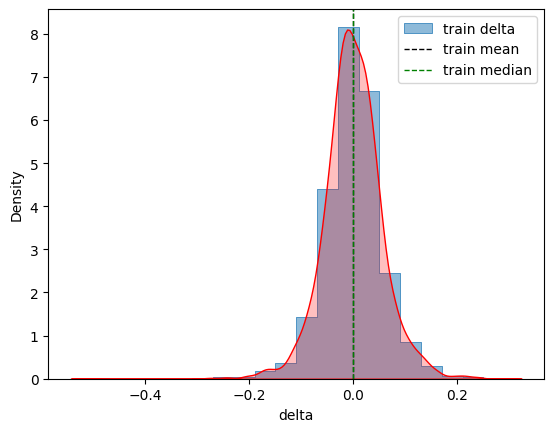

In [9]:
hist = sns.histplot(y_train, bins=20, alpha=0.5, label='train delta', stat='density', common_norm=False, element='step', fill=True, linewidth=0.5)
# add KDE
sns.kdeplot(y_train, color='red', linewidth=1, fill=True)

plt.axvline(y_train.mean(), color='black', linestyle='dashed', linewidth=1, label='train mean')
plt.axvline(y_train.median(), color='green', linestyle='dashed', linewidth=1, label='train median')

plt.legend()
plt.show()

In [10]:
linreg = smf.ols('delta ~ interest_rate', data=train).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  delta   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.650
Date:                Mon, 09 Sep 2024   Prob (F-statistic):              0.104
Time:                        22:26:18   Log-Likelihood:                 5017.9
No. Observations:                3460   AIC:                        -1.003e+04
Df Residuals:                    3458   BIC:                        -1.002e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0054      0.003     -1.897      0.058      -0.011       0.000
interest_rate     0.0017      0.001      1.628      0.104      -0.000       0.004
==============================================================================
Omnibus:                      311.335   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1858.846
Skew:                          -0.183   Prob(JB):                         0.00
Kurtosis:                       6.572   Cond. No.                         9.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
a_value = linreg.params[1]
b_value = -1 * linreg.params[0] / a_value
ir_t = x_train.values[-1] # last value of interest rate on training set
linreg_mse = linreg.mse_resid # MSE for Residuals / Variance for the model
print(f' a: {a_value} \n b: {b_value} \n σ: {linreg_mse} \n last training data interest rate: {ir_t}')

 a: 0.0016943204602467626 
 b: 3.194672148468571 
 σ: 0.00322172276727906 
 last training data interest rate: 0.93


In [12]:
# forecasting with Vasicek model formula
vasicek_pred = []
for day in tqdm(range(len(test))):
    new_ir = ir_t * np.exp(-1 * a_value * day) + b_value * (1 - np.exp(-1 * a_value * day))
    new_var = (1 - np.exp(-2 * a_value * day)) * linreg_mse ** 2 / (2 * a_value)
    vasicek_pred.append([new_ir, new_var])

vasicek_pred_df = pd.DataFrame(vasicek_pred, columns=['interest_rate', 'variance'])
vasicek_pred_df['Date'] = test['Date'].values
vasicek_pred_df = vasicek_pred_df[['Date', 'interest_rate', 'variance']]
vasicek_pred_df

100%|██████████| 921/921 [00:00<00:00, 99212.91it/s]


,Date,interest_rate,variance
0,2021-01-04,0.930000,0.000000
1,2021-01-05,0.933834,0.000010
2,2021-01-06,0.937661,0.000021
3,2021-01-07,0.941482,0.000031
4,2021-01-08,0.945296,0.000041
...,...,...,...
916,2024-08-29,2.714959,0.002926
917,2024-08-30,2.715771,0.002926
918,2024-09-03,2.716582,0.002927
919,2024-09-04,2.717391,0.002927


In [13]:
# long run forecast
ir_long = b_value
vol_long = linreg_mse / (2 * a_value)
print(f'Long run interest rate: {ir_long} \nLong run variance: {vol_long}')

Long run interest rate: 3.194672148468571 
Long run variance: 0.9507418587183457


In [14]:
# OLS Prediction / forecasting with linear regression model
pred = linreg.predict(x_test)
linreg_mse = np.mean((pred - y_test) ** 2)
pred, linreg_mse, linreg.rsquared

(3609   -0.003837
 3610   -0.003786
 3611   -0.003651
 3612   -0.003583
 3613   -0.003498
           ...   
 4562    0.001144
 4563    0.001212
 4565    0.001093
 4566    0.000975
 4567    0.000907
 Length: 921, dtype: float64,
 0.0043283329468165625,
 0.0007657019700527679)

In [15]:
ir4ols = ir.loc[len(train) - 1:, ['Date', 'interest_rate']]
ir4ols['interest_rate'] = ir4ols['interest_rate'].shift(1)
ir4ols.loc[:, 'interest_rate'] = ir4ols.loc[:, 'interest_rate'] + pred.values[1]
ir4ols = ir4ols.dropna()
ir4ols

,Date,interest_rate
3460,2020-06-09,0.876214
3461,2020-06-10,0.836214
3462,2020-06-11,0.746214
3463,2020-06-12,0.656214
3464,2020-06-15,0.706214
...,...,...
4562,2024-08-29,3.836214
4563,2024-08-30,3.866214
4565,2024-09-03,3.906214
4566,2024-09-04,3.836214


In [16]:
ols_vasicek = pd.merge(ir4ols, vasicek_pred_df, on='Date', suffixes=('_ols', '_vasicek'))
ols_vasicek

,Date,interest_rate_ols,interest_rate_vasicek,variance
0,2021-01-04,0.926214,0.930000,0.000000
1,2021-01-05,0.926214,0.933834,0.000010
2,2021-01-06,0.956214,0.937661,0.000021
3,2021-01-07,1.036214,0.941482,0.000031
4,2021-01-08,1.076214,0.945296,0.000041
...,...,...,...,...
916,2024-08-29,3.836214,2.714959,0.002926
917,2024-08-30,3.866214,2.715771,0.002926
918,2024-09-03,3.906214,2.716582,0.002927
919,2024-09-04,3.836214,2.717391,0.002927


In [17]:
mse = np.mean((ols_vasicek['interest_rate_ols'] - ols_vasicek['interest_rate_vasicek']) ** 2)
mse

1.5237028111107265

In [20]:
og_ols_vasicek = pd.merge(ols_vasicek, test, on='Date').drop(columns= ['delta'])
og_ols_vasicek

,Date,interest_rate_ols,interest_rate_vasicek,variance,interest_rate
0,2021-01-04,0.926214,0.930000,0.000000,0.93
1,2021-01-05,0.926214,0.933834,0.000010,0.96
2,2021-01-06,0.956214,0.937661,0.000021,1.04
3,2021-01-07,1.036214,0.941482,0.000031,1.08
4,2021-01-08,1.076214,0.945296,0.000041,1.13
...,...,...,...,...,...
916,2024-08-29,3.836214,2.714959,0.002926,3.87
917,2024-08-30,3.866214,2.715771,0.002926,3.91
918,2024-09-03,3.906214,2.716582,0.002927,3.84
919,2024-09-04,3.836214,2.717391,0.002927,3.77


In [22]:
# OLS did better than Vasicek
og_vas_mse = np.mean((og_ols_vasicek['interest_rate'] - og_ols_vasicek['interest_rate_vasicek']) ** 2)
og_ols_mse = np.mean((og_ols_vasicek['interest_rate'] - og_ols_vasicek['interest_rate_ols']) ** 2)
og_vas_mse, og_ols_mse

(1.5352539404705978, 0.004360050140033038)